In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna.phase_retrieval_problem import retrieve_phase
from svetlanna.phase_retrieval_problem import SetupLike
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.units import ureg

# Задача восстановления фазы: использование низкоуровневого прикладного программного интерфейса

Если возникает необходимость использовать уникальную целевую функцию для решения задачи восстановления фазы, то необходимо использовать класс `SetupLike` из модуля `svetlanna.phase_retrieval`.

У этого класса должны быть определены методы `.forward()` и `.reverse()`, определяющие решения задач прямого и обратного распространения соответственно. 

## Создание расчетной сетки с использованием класса `SimulationParameters`

In [2]:
# размер экрана
lx = 10 * ureg.mm
ly = 10 * ureg.mm

# количество точек в расчетной сетке
Nx = 1024
Ny = 1024

# длина волны света
wavelength = 1064 * ureg.nm

# фокальное расстояние линзы
focal = 10 * ureg.cm
# радиус линзы
r = 1 * ureg.cm
# расстояние между экраном и линзой
distance = focal * 1.

# радиус перетяжки пучка Гаусса
w0 = 1 * ureg.mm

sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [3]:
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Пример создания класса, наследованного от родительского класса `SetupLike`

Создадим класс PersonalSetup, в котором указаны методы, решающие задачу прямого и обратного распространения

In [4]:
class PersonalSetup(SetupLike):
    def __init__(self, elements: list):
        super().__init__()

        self.elements = elements
    def forward(self, wavefront: Wavefront) -> Wavefront:
        for element in self.elements:
            wavefront = element.forward(wavefront)

        return wavefront
    def reverse(self, wavefront: Wavefront) -> Wavefront:
        for element in reversed(self.elements):
            wavefront = element.reverse(wavefront)

        return wavefront

## Создание оптической системы с помощью созданного класса PersonalSetup

In [5]:
incident_wavefront = Wavefront.gaussian_beam(
    simulation_parameters=sim_params,
    waist_radius=w0,
    distance=distance
)

source_intensity = incident_wavefront.intensity

lens = elements.ThinLens(
    simulation_parameters=sim_params,
    focal_length=focal,
    radius=r
)

field_after_lens = lens.forward(incident_wavefront=incident_wavefront)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=distance,
    method="AS"
)

output_field = free_space.forward(incident_wavefront=field_after_lens)

target_intensity = output_field.intensity

In [6]:
personal_setup = PersonalSetup(elements=[free_space])

## Решение задачи восстановления фазы с использованием класса PersonalSetup

In [7]:
result_hio = retrieve_phase(
    source_intensity=source_intensity,
    optical_setup=personal_setup,
    target_intensity=target_intensity,
    method='HIO',
    options= {
        'tol': 1e-16,
        'maxiter': 12,
        'constant_factor': 0.9,
        'disp': False
    }
)

In [8]:
phase_distribution_hio = result_hio.solution

niter_hio = result_hio.number_of_iterations

error_mass_gs = result_hio.cost_func_evolution

## Решение прямой задачи дифракции с восстановленным распределением фазы

In [9]:
layer = elements.DiffractiveLayer(
    simulation_parameters=sim_params,
    mask=phase_distribution_hio
)

field_after_layer = layer.forward(incident_wavefront=incident_wavefront)
output_field_retrieved = free_space.forward(incident_wavefront=field_after_layer)

target_intensity_retrieved = output_field_retrieved.intensity

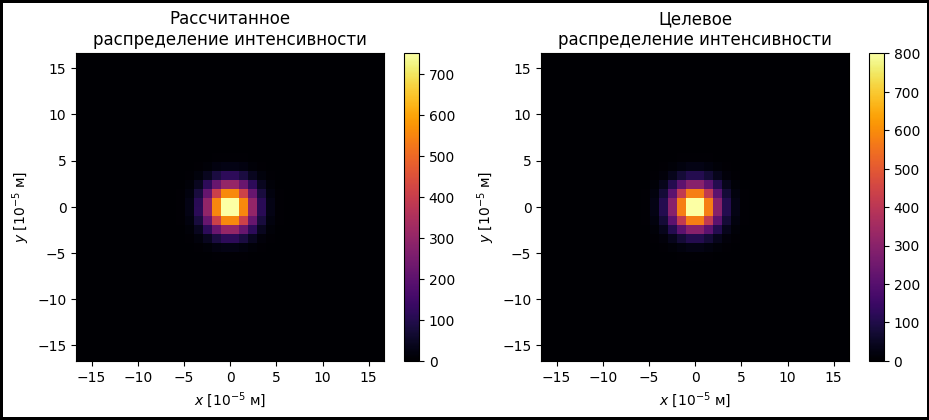

In [10]:
fig, ax = plt.subplots(
    1, 2, figsize=(11, 4), edgecolor='black', linewidth=3, frameon=True
)

scale_factor = 1e5
x_grid_scaled = x_grid * scale_factor
y_grid_scaled = y_grid * scale_factor

im1 = ax[0].pcolormesh(x_grid_scaled, y_grid_scaled, target_intensity_retrieved, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Рассчитанное\nраспределение интенсивности')
ax[0].set_xlabel('$x$ [$10^{-5}$ м]')
ax[0].set_ylabel('$y$ [$10^{-5}$ м]')
ax[0].set_xlim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
ax[0].set_ylim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(x_grid_scaled, y_grid_scaled, target_intensity, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Целевое\nраспределение интенсивности')
ax[1].set_xlabel('$x$ [$10^{-5}$ м]')
ax[1].set_ylabel('$y$ [$10^{-5}$ м]')
ax[1].set_xlim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
ax[1].set_ylim(-w0 / 6 * scale_factor, w0 / 6 * scale_factor)
fig.colorbar(im2, ax=ax[1])

plt.show()

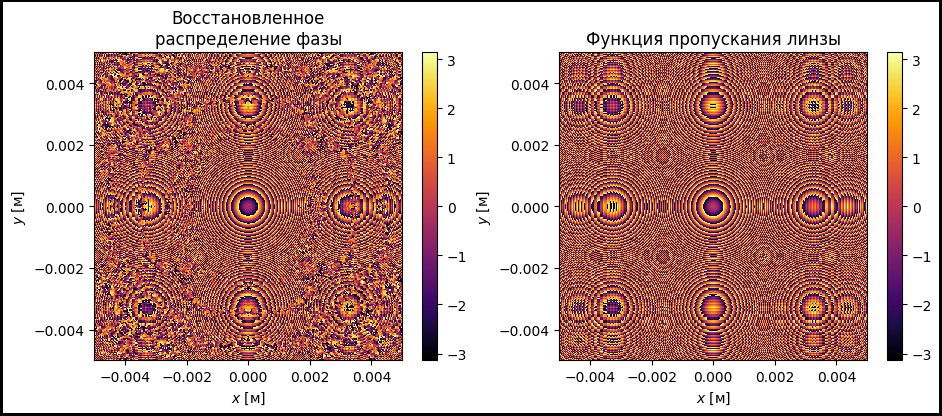

In [11]:
fig, ax = plt.subplots(
    1, 2, figsize=(11, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(x_grid, y_grid, phase_distribution_hio, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title('Восстановленное\nраспределение фазы')
ax[0].set_xlabel('$x$ [м]')
ax[0].set_ylabel('$y$ [м]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(x_grid, y_grid, torch.real(torch.log(lens.transmission_function) / 1j), cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title('Функция пропускания линзы')
ax[1].set_xlabel('$x$ [м]')
ax[1].set_ylabel('$y$ [м]')
fig.colorbar(im2)

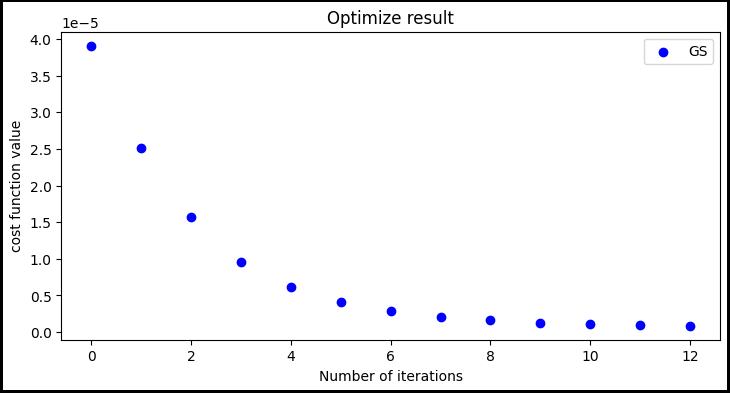

In [12]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)

ax.set_title(r'Optimize result')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('cost function value')

n_hio = np.arange(0, niter_hio+1)
ax.scatter(n_hio, error_mass_gs, label='GS', color='blue')

ax.legend()